<h1>ALG_004_EXP_001-Baseline-MacLean_et_al-Numba</h1>
<h1>Introduction</h1>
<p>As it has been previously established (ALG_001-EXP_001-Baseline) runtime optimisation had to take place in order to facilitate&nbsp; efficient experimentation. This experiment aims to build upon the previous one &nbsp;of this kind (<a href="ALG_003_EXP_001-Baseline-MacLean_et_al-Parallel_version.ipynb">ALG_003_EXP_001-Baseline-MacLean_et_al-Parallel_version</a>) which executed scanline matching in parallel. Though, code optimisation could have improved on the previous version, it would not have been satisfactory. In this experiment, an extension library, namely Numba (Numba, 2020)is used to further improve on the performance of the algorithm</p>
<h1>Abstract</h1>
<p>The functions used in the preceding algorithms were converted &nbsp;into ones that are compatible with Numba. The achieved runtimes were approximately 7 times faster including the translation of python code to bytecode which was estimated to be around 5-7 seconds. It was regarded as a sufficient improvement on the runtimes.</p>
<h1>Relevant theory</h1>
<h2>Numba</h2>
<p>Numba is an extension library for python. Its main feature is the support of Numpy syntax and function names therefore conversion from one to another is not necessary. As long as the provided Numpy function is supported by Numba it entails a simple import statement replacement and usage of decorators. Additionally, it supports NVIDIA's CUDA and AMD's ROCm drivers as well, therefore running the code on GPU&rsquo;s is also possible (Numba, 2020). Though, it would need additional effort.</p>
<p>It achieves its high performance by translating python code into byte code whose performance competes with c++&rsquo;s.</p>
<h2>NumbaSimpleMatcher</h2>
<p>The code was &nbsp;refactored in multiple aspects. As a first step, the plainly object oriented approach was replaced by a set of functions and a wrapper class (NumbaSimpleMatcher) for these functions were added so as to facilitate the usage of the code. Secondly, the code, while attempting to maintain a reasonable clarity, was also optimized (multiple loops were eliminated).</p>

<h1>Method</h1>
<p>As it had been done before, two scenes of the Middlebury 2003 dataset were used. Match, gap and egap values were initialised to 60, -20, -1. Then benchmarking, logging and saving the results ensued. Comparison, as in the previous cases, was done to the previous versions in terms of runtime and accuracy.</p>
<h1>Results and discussion</h1>
<p>The test was successful, the achieved runtime improvement was of a factor of 7. Decrease in accuracy was not measured. For visualisations please visit ALG_003_EXP_001-VIS. However, runtimes ranging from 40 to 70 seconds were still not regarded as efficient enough, therefore further optimisation was decided in this regard.</p>
<h1>Conclusion</h1>
<p>The achieved runtimes were regarded as satisfactory, the resolution was that the project could move forward into experimenting with modifications of the algorithms.</p>
<h2>References</h2>
<ol>
<li>Numba (2020) <em>Numba: A High Performance Python Compiler</em>. Available at: http://numba.pydata.org/ (Accessed: 9 July 2020).</li>
</ol>


In [5]:
###################################################################
# Built-in modules ################################################
###################################################################

import sys
import os
sys.path.append(os.path.join("..", ".."))

import numpy as np
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc

import math
import time
import glob

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.NumbaSimpleMatcher import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils.Metrix import Wrapper as me
import project_helpers

###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [6]:

ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_004_EXP_001-Baseline-MacLean_et_al-Numba"

INIT_METHOD = "maclean"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003
EXP_PARAMS = dict()

#  Loading the dataset and visualising the results

In [ ]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

# Benchmarking and evaluation

In [ ]:
###################################################################
# 3.1 Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

progress_bar = SimpleProgressBar.get_instance()

MATCH = 60
GAP = -20
EGAP = -1

results = []
SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)
saved_image_names = []

matcher = m(MATCH, GAP, EGAP)

EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

In [ ]:
###################################################################
# 3.2 Matching ####################################################
###################################################################



EXP_PARAMS["init_method"] = "maclean_et_al"
progress_counter = 1
steps_to_be_taken = 2

for i, scene in enumerate(SCENES):
    EXP_PARAMS["scene"] = scene
    EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
    EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
    occ = loaded_imgs_and_paths[i][0][3]
    gt = loaded_imgs_and_paths[i][0][2]

    matcher.set_images(loaded_imgs_and_paths[i][0][0].astype(np.float64), loaded_imgs_and_paths[i][0][1].astype(np.float64))

    tic = time.time()

    matcher.configure_instance(initialize_matrix_template= matcher.matrix_template_intit[1])

    tic=time.time()

    x,raw_disp_map = matcher.test_pipeline()
    toc = time.time()

    EXP_PARAMS["runtime"] = toc-tic

    disp = raw_disp_map
    disp = 4*disp
    
    results.append(disp)
    temp_path = u.save_disparity(SAVE_PATH, disp)
    EXP_PARAMS["image_filename"] = temp_path

    saved_image_names.append(os.path.split(temp_path)[-1])
    

    EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False

    EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
    BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

    csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

    EXP_PARAMS["are_occlusions_errors"]  = True
    EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
    BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

    csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())
    
    progress_bar.progress_bar(progress_counter, steps_to_be_taken, header= "Experiment on patch sizes in progress: ", progress_bar_steps=40)
    progress_counter+=1

In [3]:

import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="abs_error", inplace=True) 
experiment_log.head(30)


,experiment_id,match,gap,egap,algo,init_method,dataset,scene,image_filename,img_res,...,are_occlusions_errors,abs_error,mse,avg,eucledian,bad1,bad2,bad4,bad8,runtime
0,ALG_004_EXP_001-Baseline-MacLean_et_al-Numba,60,-20,-1,components.matchers.NumbaSimpleMatcher,maclean_et_al,middlebury,teddy,experiments\disparities\ALG_004_EXP_001-Baseli...,450x375,...,False,1482211.0,863.643423,10.038611,11292.378625,0.662481,0.503884,0.351362,0.188688,13.537151
2,ALG_004_EXP_001-Baseline-MacLean_et_al-Numba,60,-20,-1,components.matchers.NumbaSimpleMatcher,maclean_et_al,middlebury,cones,experiments\disparities\ALG_004_EXP_001-Baseli...,450x375,...,False,1583044.0,812.389978,10.999013,10813.142004,0.663000,0.545822,0.393570,0.244021,6.328106
1,ALG_004_EXP_001-Baseline-MacLean_et_al-Numba,60,-20,-1,components.matchers.NumbaSimpleMatcher,maclean_et_al,middlebury,teddy,experiments\disparities\ALG_004_EXP_001-Baseli...,450x375,...,True,3380770.0,2284.108150,20.446886,19433.568329,0.697824,0.554807,0.417729,0.270104,13.537151
3,ALG_004_EXP_001-Baseline-MacLean_et_al-Numba,60,-20,-1,components.matchers.NumbaSimpleMatcher,maclean_et_al,middlebury,cones,experiments\disparities\ALG_004_EXP_001-Baseli...,450x375,...,True,3725448.0,2859.874162,22.810588,21611.976032,0.701135,0.595680,0.459751,0.324104,6.328106


<ipython-input-7-4e26aad9974f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-4e26aad9974f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-4e26aad9974f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



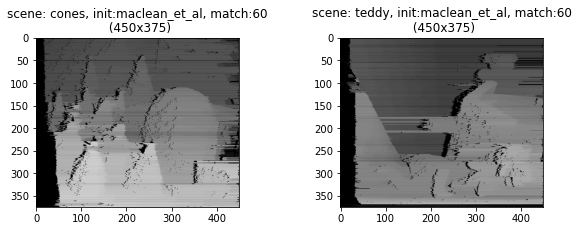

In [7]:

image_reader_func = lambda filepath: cv2.imread(str(project_helpers.fix_win_rel_paths(filepath)))

filtered_log= experiment_log[experiment_log["are_occlusions_errors"] == False]
filtered_log["loaded_imgs"] = [image_reader_func(filepath) for filepath in filtered_log["image_filename"]]
filtered_log["annotation"] = [("scene: {0}, init:{1}, match:{2}".format(scene, init, m)) for scene, init, m in filtered_log[["scene", "init_method", "match"]].values]
filtered_log.sort_values(by=["match", "scene"], inplace=True)
plu.plot_images(filtered_log["loaded_imgs"].values, filtered_log["annotation"].values)

For result analysis please visit <a href="ALG_004_EXP_001-VIS.ipynb">ALG_004_EXP_001-VIS</a>